# Generalized Orthogonal Least-Squares
https://arxiv.org/pdf/1602.06916.pdf

In [1]:
%pylab inline
import seaborn
seaborn.set_context('talk')

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sys
sys.path.insert(0, 'build')
import _gols

In [3]:
def gols_solve(dictionary, y, sparsity, L):
    import bisect
    import numpy
    '''
    dictionary is a n x m matrix
    looking for y = A * x with x super-sparse
    '''
    A = dictionary
    k = sparsity
    n, m = A.shape
    Port = numpy.eye(n)
    S = set()
    I = range(m)
    for i in range(0, min(k, n / L)):
        Porta = numpy.array([Port.dot(A[:, j]) for j in I])
        Porta = numpy.divide(Porta, numpy.linalg.norm(Porta, axis=1)[:,None])
        gamma = numpy.array([abs(y.dot(porta)) for porta in Porta])
        L_largest = gamma.argsort()[-L:]
        largest_indices = [I[j] for j in L_largest]
        [S.add(I[j]) for j in L_largest]
        [I.pop(bisect.bisect_left(I, j)) for j in largest_indices]
        D = Port
        for j in largest_indices:
            Da = D.dot(A[:, j])
            d = Da / numpy.linalg.norm(Da)
            D = D - numpy.outer(d, d)
        Port = D
    As = numpy.array([A[:, j] for j in S]).T
    xs, _, _, _ = numpy.linalg.lstsq(As, y)
    return S, xs

In [4]:
x = numpy.linspace(0, 1, 1024)
A = []
numpy.random.seed(0)
for i in range(200):
    sigma, pos = numpy.random.random(2)
    A.append(numpy.exp(-(x-pos)**2/(2*sigma**2)))
A = numpy.array(A).T
y = numpy.sin(2 * numpy.pi * x) + 0.5 * numpy.sin(3 * numpy.pi * x)

In [5]:
%%time
xcpu = []
ycpu = []
for sparsity in range(1, 20):
    As, ys = gols_solve(A, y, sparsity, 4)
    yre = numpy.array([A[:,j] for j in As]).T.dot(ys)
    ycpu.append(numpy.linalg.norm(yre - y))
    xcpu.append(sparsity)

xerror = []
yerror = []
for sparsity in range(1, 20):
    cols = _gols.gols_solve(A.T, y, sparsity, 4)
    As = numpy.array([A[:,j] for j in cols]).T
    xs, _,_,_ = numpy.linalg.lstsq(As, y)
    yre = As.dot(xs)
    yerror.append(numpy.linalg.norm(yre - y))
    xerror.append(sparsity)
    
with open('kahan-data.pkl', 'r') as f:
    import pickle
    _, _, xx, yy = pickle.loads(f.read())



CPU times: user 27.1 s, sys: 25 s, total: 52.1 s
Wall time: 6.83 s


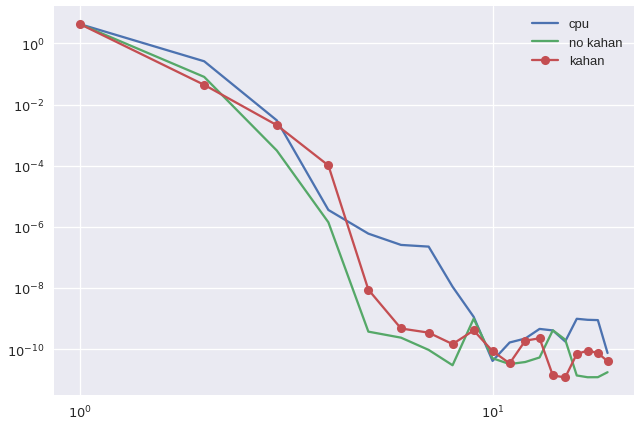

In [6]:
loglog(xcpu, ycpu, label='cpu')
loglog(xerror, yerror, label='no kahan')
loglog(xx, yy, '-o',label='kahan' )
legend()

In [7]:
%time
xerror3 = []
yerror3 = []
for sparsity in range(1, 20):
    As, ys = gols_solve(A, y, sparsity, 4)
    yre = numpy.array([A[:,j] for j in As]).T.dot(ys)
    yerror3.append(numpy.linalg.norm(yre - y))
    xerror3.append(sparsity)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.1 µs


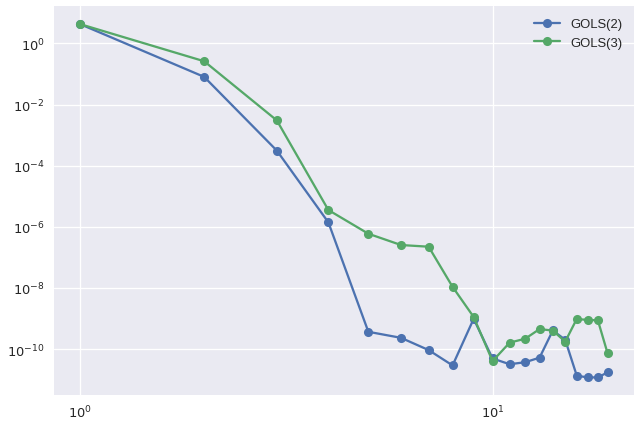

In [8]:
loglog(xerror, yerror, '-o', label='GOLS(2)')
loglog(xerror3, yerror3, '-o', label='GOLS(3)')
legend()

In [9]:
%time
xerror = []
yerror = []
for sparsity in range(1, 50):
    cols = _gols.gols_solve(A.T, y, sparsity, 2)
    As = numpy.array([A[:,j] for j in cols]).T
    xs, _,_,_ = numpy.linalg.lstsq(As, y)
    
    yre = As.dot(xs)
#     As, ys = gols_solve(A, y, sparsity, 3)
#     yre = numpy.array([A[:,j] for j in As]).T.dot(ys)
    yerror.append(numpy.linalg.norm(yre - y))
    xerror.append(sparsity)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 3.81 µs


In [10]:
## %time
xerror3 = []
yerror3 = []
for sparsity in range(1, 20):
    cols = _gols.gols_solve(A.T, y, sparsity, 4)
    As = numpy.array([A[:,j] for j in cols]).T
    xs, _,_,_ = numpy.linalg.lstsq(As, y)
    
    yre = As.dot(xs)
#     As, ys = gols_solve(A, y, sparsity, 3)
#     yre = numpy.array([A[:,j] for j in As]).T.dot(ys)
    yerror3.append(numpy.linalg.norm(yre - y))
    xerror3.append(sparsity)

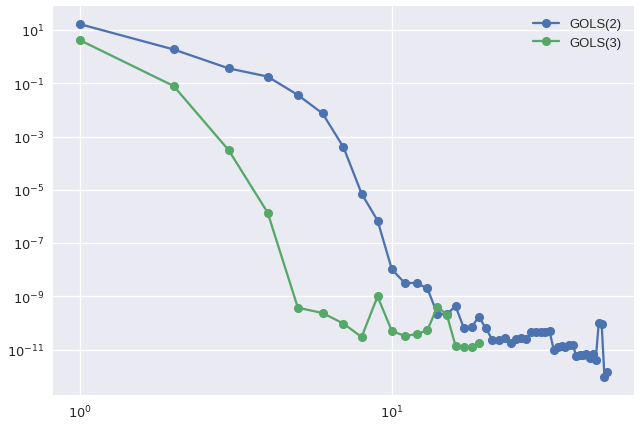

In [11]:
loglog(xerror, yerror, '-o', label='GOLS(2)')
loglog(xerror3, yerror3, '-o', label='GOLS(3)')
legend()

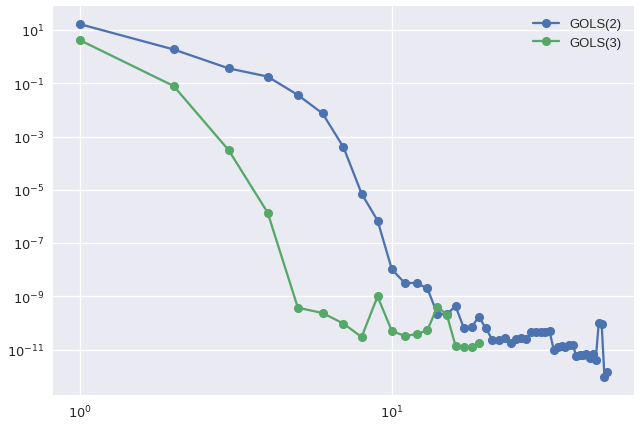

In [12]:
loglog(xerror, yerror, '-o', label='GOLS(2)')
loglog(xerror3, yerror3, '-o', label='GOLS(3)')
legend()

In [13]:
# import pickle
# with open('kahan-data.pkl', 'w') as f:
#     f.write(pickle.dumps((xerror, yerror, xerror3, yerror3)))